In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
from copy import deepcopy

plt.style.use('default')
# plt.style.use('./Dropbox/voxels/regress/mary.mplstyle')
# plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth']= 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "Times New Roman"


In [2]:
mat = np.zeros((3, 3, 6))
mat[2, 0, 1]=-1
mat[2, 0, 4]=1
mat[2, 1, 0]=1
mat[2, 1, 3]=-1
mat[1, 0, 2]=1
mat[1, 0, 5]=-1
mat[1, 2, 0]=-1
mat[1, 2, 3]=1
mat[0, 1, 2]=1
mat[0, 1, 5]=-1
mat[0, 2, 1]=-1
mat[0, 2, 4]=1  

# build connection map 
def check_servo_mappings(s, ee_pos):
    connected_servos=[]
    for servo in s:  
        if servo.pos[servo.act_dim] == ee_pos[servo.act_dim]: 
            connected_servos.append(servo)
    return(connected_servos) 

class ee:
    def __init__(self, x, y, z, node_id, s):
        self.pos=(x, y, z)
        self.node_id = node_id
        self.disp=np.zeros((3))
        self.control = check_servo_mappings(s, self.pos)

class servo:
    def __init__(self, x, y, z, act_dim, gait):
        self.pos = (x, y, z)
        self.act_dim=act_dim # 1 = 0134, 2=0235, 3=1245
        if act_dim==0:
            self.connected=z+2
        elif act_dim==1:
            self.connected=y+2
        elif act_dim==2:
            self.connected=x+2
        self.gait=gait
        self.disp = 0 

def sim(e, *t):    
    simdisp=[]
    
    if t !=():  
        for i,end in enumerate(e):   
            for time in t[0]:
                end.disp=0
                for controls in end.control: 
                    controls.disp = controls.gait[time] 
                    # calculate displacements as ind sum of components 
                    end.disp += controls.disp*mat[controls.act_dim, :, end.node_id]     
                if end.control==[]: # if no connected servos
                    simdisp.append(np.zeros((3))) 
                else: 
                    simdisp.append(deepcopy(end.disp)) 
    else: 
        
        for i,end in enumerate(e): 
            end.disp=0
            for controls in end.control: 
                controls.disp = controls.gait
                # calculate displacements as ind sum of components 
                end.disp += controls.disp*mat[controls.act_dim, :, end.node_id]
                # CHECKERBOARD PARITY, displacement direction:
                for i in range(3): 
                    #if movement in dim, check dir:
                    if controls.disp*mat[controls.act_dim, :, end.node_id][i]!=0.:  
                        kEnd=0
                        kControl=0 
                        if end.pos[i]%4 in (0, 1): 
                            kEnd=1 
                        if (controls.pos[i]%4) in (0, 1):  
                            kControl=1
                        if kEnd!=kControl: 
                            end.disp[i]*=-1 
            
            if end.control==[]: # if no connected servos
                simdisp.append(np.zeros((3))) 
            else:
                simdisp.append(deepcopy(end.disp))
    return(np.array(simdisp))         

In [3]:
# EXAMPLE 1
s1 = [servo(2, 1, 1, 1, -5)] # servo(x, y, z, act_dim, displacement)
ee1 = ee(0, 1, 3, 0, s1) # end effector(x, y, z, node_id, servo_list)
ee2 = ee(1, 1, 4, 5, s1)
e =[ee1, ee2]
 
results = sim(e)
print(results)

[[ 0.  0. -5.]
 [-5.  0.  0.]]


In [4]:
# EXAMPLE 2  
s1 = servo(2, 1, 1, 1, 5) # blue, servo(x, y, z, act_dim, displacement)
s2 = servo(1, 2, 1, 0, -5) # yellow
s3 = servo(2, 3, 1, 1, 5) # red
s4 = servo(3, 3, 1, 0, -5) # green 
s=[s1, s2, s3, s4]

ee_yr = ee(1, 3, 4, 5, s) # end effector(x, y, z, node_id, servo_list)
ee_yb = ee(1, 1, 4, 5, s)
ee_gb = ee(3, 1, 4, 5, s)
ee_gr = ee(3, 3, 4, 5, s)
e = [ee_yr, ee_yb, ee_gb, ee_gr]
 
results = sim(e)
print(results)

[[ 5.  5.  0.]
 [ 5. -5.  0.]
 [-5. -5.  0.]
 [-5.  5.  0.]]


In [5]:
# EXAMPLE 3
s1 = [servo(2, 1, 1, 1, -5)] # servo(x, y, z, act_dim, displacement)
ee1 = ee(4, 1, 3, 3, s1) # end effector(x, y, z, node_id, servo_list)
ee2 = ee(1, 1, 2, 5, s1)

e =[ee1, ee2]

results = sim(e)
print(results)

[[ 0.  0.  5.]
 [-5.  0.  0.]]


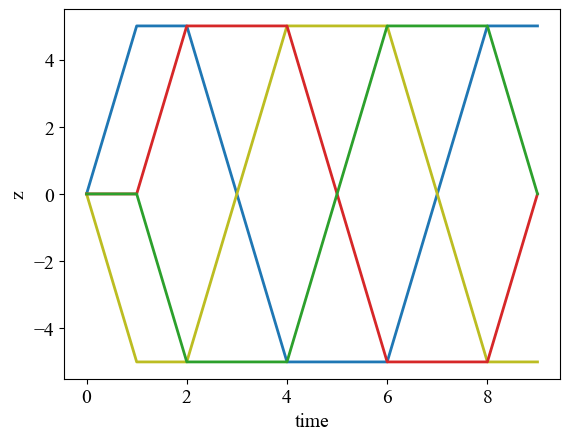

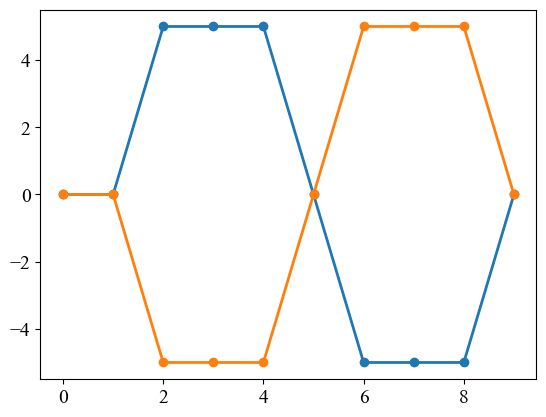

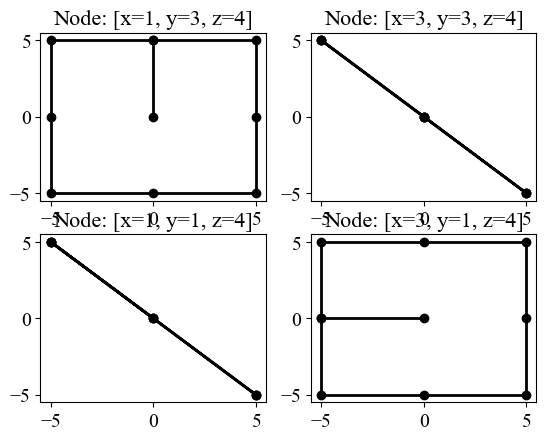

In [6]:
d=5

# cpg gait 
gait1 = (0, d,  d,  0,  -d, -d, -d, 0,  d,  d) # blue 
gait2 = (0, -d, -d, 0,  d,  d,  d,  0,  -d, -d) # yellow
gait3 = (0, 0,  d,  d,  d,  0,  -d, -d, -d,  0) # red
gait4 = (0, 0,  -d, -d, -d, 0,  d,   d,  d,  0) #green 

t=np.arange(len(gait1))  
gait = [gait1,gait2,gait3,gait4]
gaitsim=gait 

plt.plot(t, gait[0],'C0') # blue
plt.plot(t, gait[1], 'C8') # yellow 
plt.plot(t, gait[2], 'C3') # red
plt.plot(t, gait[3], 'C2') # green 
plt.xlabel('time')
actdim=['x', 'y', 'z']
plt.ylabel(actdim[2])
plt.show()

# index 0, using planes in xyz to def unique node pos
# def act dim to indicate square
# inputs = xyz plane, act dim, gait
s1 = servo(2, 1, 1, 1, gait[0]) # blue, servo(x, y, z, act_dim, displacement)
s2 = servo(1, 2, 1, 0, gait[1]) # yellow
s3 = servo(2, 3, 1, 1, gait[2]) # red
s4 = servo(3, 2, 1, 0, gait[3]) # green  
s=[s1, s2, s3, s4] 

# define one end of end effector with smaller index 
# class params: xyz plane, node id, active servo list
ee_yr = ee(1, 3, 4, 5, s) # end effector(x, y, z, node_id, servo_list)
ee_yb = ee(1, 1, 4, 5, s)
ee_gb = ee(3, 1, 4, 5, s)
ee_gr = ee(3, 3, 4, 5, s)

ee_rf = ee(4, 3, 1, 3, s)
ee_lf = ee(3, 4, 1, 4, s)
e = [ee_yr, ee_yb, ee_gb, ee_gr, ee_rf, ee_lf]
# e = [ee_yr, ee_yb, ee_gb, ee_gr]

res = sim(e, t)
    
yr = res[:len(t)]
yb = res[len(t):2*len(t)]
gb = res[2*len(t):3*len(t)]
gr = res[3*len(t):4*len(t)] 

rf = res[4*len(t):5*len(t)] 
lf = res[5*len(t):6*len(t)] 

plt.figure()
plt.plot(rf[:, 2],'o-')
plt.plot(lf[:, 2],'o-')
plt.show()

f = plt.figure()
plt.subplot(2, 2, 1)
ax = f.gca()
plt.title('Node: [x=1, y=3, z=4]')
plt.plot(yr[:, 0], yr[:, 1],'ko-')   
plt.xticks([ -5, 0, 5])
plt.yticks([ -5, 0, 5])

plt.subplot(2, 2, 2)
ax = f.gca()
plt.title('Node: [x=3, y=3, z=4]')
plt.plot(gr[:, 0], gr[:, 1], 'ko-')
plt.xticks([ -5, 0, 5])
plt.yticks([ -5, 0, 5])

plt.subplot(2, 2, 3)
ax = f.gca()
plt.title('Node: [x=1, y=1, z=4]')
plt.plot(yb[:, 0], yb[:, 1], 'ko-')
plt.xticks([ -5, 0, 5])
plt.yticks([ -5, 0, 5])

plt.subplot(2, 2, 4)
ax = f.gca()
plt.title('Node: [x=3, y=1, z=4]')
plt.plot(gb[:, 0], gb[:, 1],'ko-')  
plt.xticks([ -5, 0, 5])
plt.yticks([ -5, 0, 5])
plt.show()
